In [1]:
# this script analyzes inundation extents and relates them to water levels at Koh Khel 

# source of inundation extents: GEE script: https://code.earthengine.google.com/404c1fd0dcc9708cff48914f1370b90c

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math
from matplotlib.dates import date2num

In [16]:
# Load Data 

radarfilename = 'Radar_2div_KMeans_PA.csv' #<---------- change study area + classifier
opticalfilename = 'Sentinel_2div_KMeans_PA.csv'  #<---------- change study area + classifier

## optical data 

op =pd.read_csv(opticalfilename)

op['date'] = pd.to_datetime(op['date'])

minimum_area = op['totalarea'].max()*0.95

op = op[op['totalarea'] > minimum_area]

op['flooded'] = 100*(op['flood']/op['totalarea'])
op = op.drop(columns=['system:index', 'dry', 'flood', 'totalarea', '.geo'])
op = op.set_index('date')
op.columns = ['flood_optical']


# import files : radar
ra =pd.read_csv(radarfilename)
ra['date'] = pd.to_datetime(ra['date'])

minimum_area = ra['totalarea'].max()*0.95

ra = ra[ra['totalarea'] > minimum_area]

ra['flooded'] = 100*(ra['flood']/ra['totalarea'])
ra = ra.drop(columns=['system:index', 'dry', 'flood', 'totalarea','.geo'])
ra = ra.set_index('date')
ra.columns = ['flood_radar']
#ra.tail()

flood = ra.merge(op, how='outer', left_index=True, right_index=True)



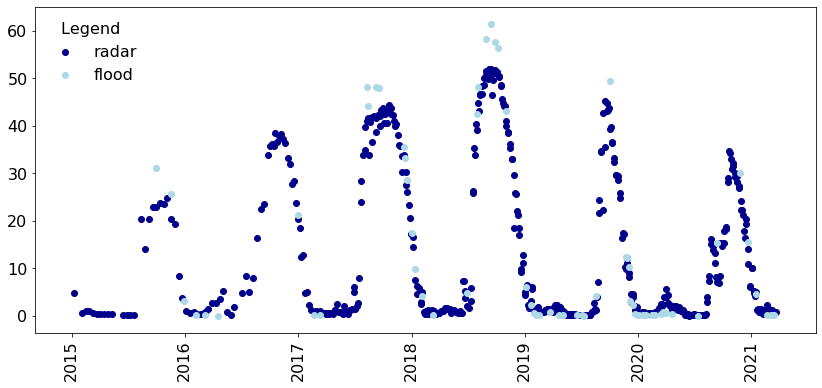

In [17]:
# Initialise the figure and axes.

fig, ax = plt.subplots(1, figsize=(14, 6))

# Set the title for the figure
#fig.suptitle('Measurments in Study Area', fontsize=15)


# define axes 
y1 = flood['flood_radar']
y2 = flood['flood_optical']

x = flood.index
x = pd.to_datetime(x)
#x = x.strftime('%Y-%m')

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend.
ax.scatter(x, y1, color="darkblue", label="radar")
ax.scatter(x, y2, color="lightblue", label="flood")

#plt.xticks(np.arange(0, len(x)+1, 5))

plt.legend(loc="upper left", title="Legend ", frameon=False)
plt.xticks(rotation = 90)

plt.show()

#fig.savefig('SA_in_situ', dpi=100)

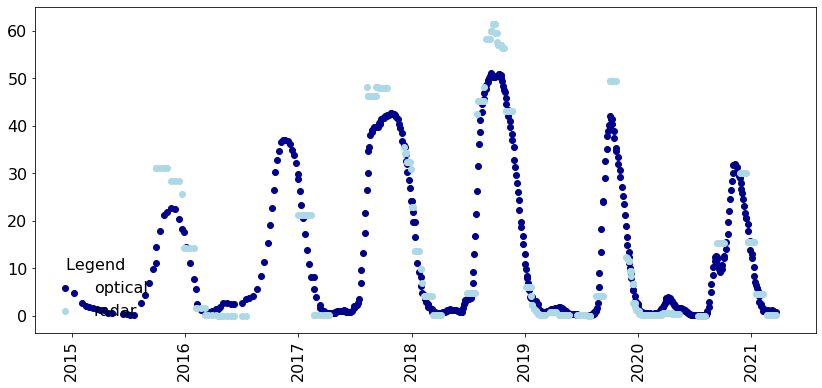

In [18]:
flood_ma = flood.rolling(center=False, window=8, min_periods=1).mean()

# Initialise the figure and axes.

fig, ax = plt.subplots(1, figsize=(14, 6))

# Set the title for the figure
#fig.suptitle('Measurments in Study Area', fontsize=15)


# define axes 
y1 = flood_ma['flood_radar']
y2 = flood_ma['flood_optical']

x = flood_ma.index
x = pd.to_datetime(x)
#x = x.strftime('%Y-%m')

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend.
ax.scatter(x, y1, color="darkblue", label="optical")
ax.scatter(x, y2, color="lightblue", label="radar")

#plt.xticks(np.arange(0, len(x)+1, 5))

plt.legend(loc="lower left", title="Legend ", frameon=False)
plt.xticks(rotation = 90)

plt.show()

#fig.savefig('SA_in_situ', dpi=100)

In [19]:
flood_op = op
flood_op.columns = ['flood']

flood_ra = ra 
flood_ra.columns = ['flood']

flood_all = pd.concat([flood_op, flood_ra])
flood_all = flood_all.groupby('date').mean()
flood_all = flood_all.sort_index()   

flood_all_ma = flood_all.rolling(center=False, window=3, min_periods=1).mean()

flood_all.tail()



,flood
date,
2021-03-10,0.668782
2021-03-11,0.082927
2021-03-15,0.826249
2021-03-16,0.456858
2021-03-21,0.852053


In [20]:
date_length = 2267

daterange = pd.date_range("2015-01-01", periods=date_length, freq='D')
columns = ['empty']
 
df = pd.DataFrame(index=range(0,date_length), columns=columns)
df = df.fillna(0)
df['date'] = daterange
df = df.set_index('date')

df.tail()

,empty
date,
2021-03-12,0
2021-03-13,0
2021-03-14,0
2021-03-15,0
2021-03-16,0


In [21]:
flood_daily = pd.merge(df, flood_all_ma, how='left', left_index=True, right_index=True)
flood_daily = flood_daily.drop(columns = ['empty'])
flood_daily = flood_daily.fillna(flood_daily.interpolate(method='linear')).rolling(center=False, window=3, min_periods=1).mean()


#flood_daily.head(20)

In [22]:
# water level at Koh Kehl 

wl_long = pd.read_csv('wl_KK.csv')
wl_long['date'] = pd.to_datetime(wl_long['date'])
wl_long['date'] = wl_long['date'].dt.strftime('%Y-%m-%d')
wl_long.columns = ['huh', 'date', 'wl_long']
wl_long = wl_long.drop(columns=['huh'])
wl_long = wl_long.set_index('date')
wl_long['wl_long'] = wl_long['wl_long']-1 # <------ -1 correct for elevation 

# for data availability comparison:
wl_long.index = pd.to_datetime(wl_long.index)
wl_long1 = wl_long.resample('d').mean()#*10 # <----------- multiply by 10 for vis.

wl_KK_daily = wl_long1  
wl_KK_daily.columns = ['wl_KK']

#wl_KK_daily = wl_KK_daily.rolling(center=False, window=3, min_periods=1).mean().round(2)

wl_KK_daily.to_csv('wl_KK_smoothed.csv')

wl_KK_daily.head()

,wl_KK
date,
1990-09-05,7.16
1990-09-06,7.20
1990-09-07,7.22
1990-09-08,7.22
1990-09-09,7.21


In [23]:
flood_daily = flood_daily.merge(wl_KK_daily, how='inner', left_index=True, right_index=True)
flood_daily = flood_daily[(flood_daily.index > '2016-12-31')]

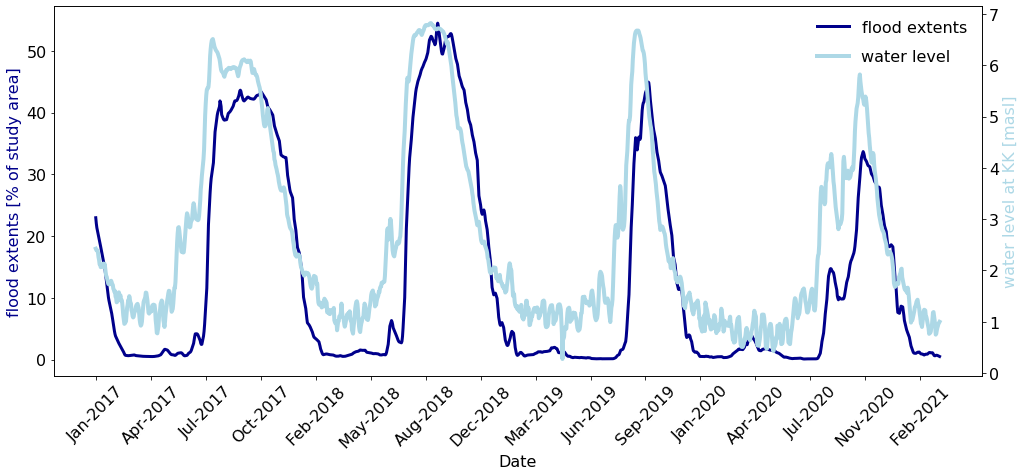

In [24]:
# Initialise the figure and axes.

fig, ax1 = plt.subplots(1, figsize=(14,6))

plt.tight_layout()

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Set the title for the figure
#fig.suptitle('Measurments in Study Area', fontsize=15)


# define axes 
y1 = flood_daily['flood']
y2 = flood_daily['wl_KK']

#x = flood_daily.index
x = date2num(pd.to_datetime(flood_daily.index))

ax2 = ax1.twinx()
ax1.plot(x, y1, color="darkblue", label="flood extents",  linewidth=3)
ax2.plot(x, y2, color="lightblue", label="water level",  linewidth=4)

#plt.legend(loc="upper left", title="Legend ", frameon=False)
ax2.legend(bbox_to_anchor=(-0.018, 0.82, 1., .102), frameon=False)
ax1.legend(bbox_to_anchor=(-0.0, 0.90, 1., .102), frameon=False)

#plt.xticks(rotation = 45)

ax1.set_xlabel('Date')
ax1.xaxis.label.set_size(16)
ax1.set_ylabel('flood extents [% of study area]', color='darkblue')
ax2.set_ylabel('water level at KK [masl]', color='lightblue')


axes = plt.gca()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%b-%Y')

ax1.xaxis.set_major_formatter(myFmt)

plt.xticks(np.arange(min(x), max(x), 100.0))


plt.setp( ax1.xaxis.get_majorticklabels(), rotation=45 )

fig.savefig('Inundations_WaterLevels_ZoneB.png', dpi=300, bbox_inches = "tight")
#fig.savefig('Inundations_WaterLevels_ZoneA.png', dpi=300, bbox_inches = "tight")


plt.show()

In [25]:
flood_daily2 = flood_daily.drop(columns=['wl_KK'])
flood_daily2.columns = ['flood_extent']
flood_daily2.head()

,flood_extent
date,
2017-01-01,22.975690
2017-01-02,22.036627
2017-01-03,21.351570
2017-01-04,20.920519
2017-01-05,20.489469


In [26]:
flood_daily2.tail()

,flood_extent
date,
2021-03-12,0.685433
2021-03-13,0.648176
2021-03-14,0.607446
2021-03-15,0.566716
2021-03-16,0.516015


In [27]:
#### export of results: 

#flood_daily2.to_csv('flood_extents_Zone2C_2017-21.csv')
flood_daily.to_csv('flood_extents_PrekArea_2015-21.csv')

In [13]:
## correlation without shift: 

flood_daily.corr()



,flood,wl_KK
flood,1.000000,0.886951
wl_KK,0.886951,1.000000


In [14]:
# correlations shift: 

flooded_ws = flood_daily

flooded_ws['flood_shift'] = flooded_ws['flood'].shift(-12)

flooded_ws.corr()


,flood,wl_KK,flood_shift
flood,1.000000,0.886951,0.947761
wl_KK,0.886951,1.000000,0.956422
flood_shift,0.947761,0.956422,1.000000


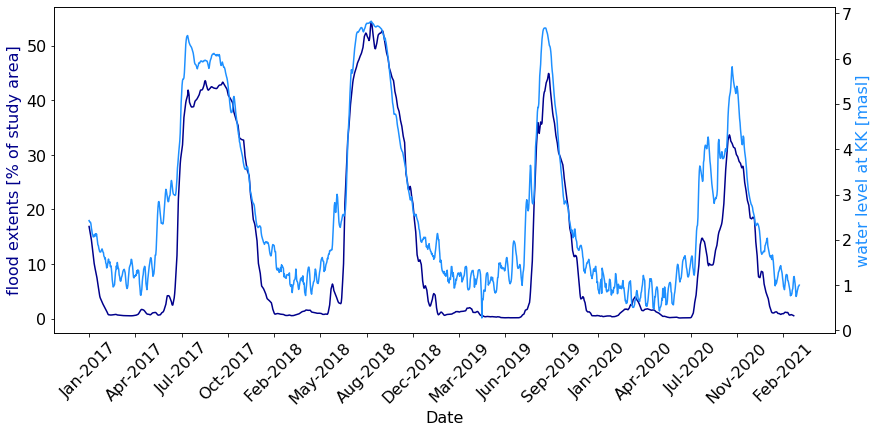

In [15]:
# visualise: 

# Initialise the figure and axes.

fig, ax1 = plt.subplots(1, figsize=(14, 6))

# Set the title for the figure
#fig.suptitle('shifted 23 days', fontsize=15)


# define axes 
y1 = flooded_ws['flood_shift']
y2 = flooded_ws['wl_KK']

#x = flood_daily.index
x = date2num(pd.to_datetime(flooded_ws.index))

ax2 = ax1.twinx()
ax1.plot(x, y1, color="darkblue", label="flood extents")
ax2.plot(x, y2, color="dodgerblue", label="water level at KK")

#plt.legend(loc="upper left", title="Legend ", frameon=False)
#ax2.legend(loc=0)
#ax1.legend(loc=1)

#plt.xticks(rotation = 45)

ax1.set_xlabel('Date')
ax1.set_ylabel('flood extents [% of study area]', color='darkblue')
ax2.set_ylabel('water level at KK [masl]', color='dodgerblue')


axes = plt.gca()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%b-%Y')

ax1.xaxis.set_major_formatter(myFmt)

plt.xticks(np.arange(min(x), max(x), 100.0))


plt.setp( ax1.xaxis.get_majorticklabels(), rotation=45 )

#fig.savefig('Inundations_WaterLevels_PrekArea_shifted', dpi=300)
#fig.savefig('Inundations_WaterLevels_ZoneB', dpi=300)

plt.show()


In [16]:
# Prek Area: calculate the delay times according to water levels for each image 

delay_PA = pd.read_csv('Inundations_WaterLevels_PA.csv', sep=';', decimal=',').round(2)
delay_PA.head(3)

mean_delay_PA = delay_PA['DelayTime'].mean()
print(mean_delay_PA)


13.81578947368421


In [17]:
# Zone 2C: calculate the delay times according to water levels for each image 

delay_2C = pd.read_csv('Inundations_WaterLevels_2C.csv', sep=';', decimal=',').round(2)
delay_2C.head(10)

mean_delay_2C = delay_2C['DelayTime'].mean()
print(mean_delay_2C)

23.17105263157895


In [18]:
# for each water level in KK, find the date that matches it, according to the table  - then check, if there is a Sentinel image for that day in the collection

def find_delay_PA(wl):
    test_value = wl
    df_temp = delay_PA.iloc[(delay_PA['WL']-test_value).abs().argsort()[:1]] #<--- match wl
    time_days = int(df_temp['DelayTime'].round(0)) #<- select corresponding delay
    return time_days

def find_delay_2C(wl):
    test_value = wl
    df_temp = delay_2C.iloc[(delay_2C['WL']-test_value).abs().argsort()[:1]] #<--- match wl
    time_days = int(df_temp['DelayTime'].round(0)) #<- select corresponding delay
    return time_days



In [19]:
## add the individual inundation delays for each wl value at KK - convert to list of dates 

wl_KK_daily['date'] = wl_KK_daily.index
wl_KK_daily['delay_PA'] = wl_KK_daily['wl_KK'].apply(find_delay_PA)
wl_KK_daily['delay_2C'] = wl_KK_daily['wl_KK'].apply(find_delay_2C)
wl_KK_daily['delay_PA'] = pd.to_timedelta(wl_KK_daily['delay_PA'], unit='d')
wl_KK_daily['Sentinel_date_PA'] = wl_KK_daily['date']+ wl_KK_daily['delay_PA']
wl_KK_daily['delay_2C'] = pd.to_timedelta(wl_KK_daily['delay_2C'], unit='d')
wl_KK_daily['Sentinel_date_2C'] = wl_KK_daily['date']+ wl_KK_daily['delay_2C']
wl_KK_daily = wl_KK_daily.drop(columns=['delay_PA'])
wl_KK_daily = wl_KK_daily.drop(columns=['delay_2C'])

#wl_KK_daily['new_date'] = (wl_KK_daily['date'] + datetime.timedelta(days=wl_KK_daily['delay']))

wl_KK_daily.tail(20)

,wl_KK,date,Sentinel_date_PA,Sentinel_date_2C
date,,,,
2021-03-03,1.050,2021-03-03,2021-03-12,2021-03-27
2021-03-04,1.180,2021-03-04,2021-03-17,2021-03-17
2021-03-05,1.190,2021-03-05,2021-03-20,2021-03-28
2021-03-06,1.110,2021-03-06,2021-03-15,2021-03-30
2021-03-07,1.030,2021-03-07,2021-03-16,2021-03-31
2021-03-08,0.920,2021-03-08,2021-03-22,2021-04-02
2021-03-09,0.750,2021-03-09,2021-03-10,2021-03-12
2021-03-10,0.770,2021-03-10,2021-03-11,2021-03-13
2021-03-11,0.835,2021-03-11,2021-03-25,2021-04-05


In [20]:
wl_KK_daily[(wl_KK_daily['date']=='2018-09-01')]

,wl_KK,date,Sentinel_date_PA,Sentinel_date_2C
date,,,,
2018-09-01,6.815,2018-09-01,2018-09-17,2018-09-23


In [21]:
wl_KK_daily['wl_KK'].max()

7.279999999999999

In [22]:
dates_PA = wl_KK_daily.drop(columns=['date', 'Sentinel_date_2C']).set_index('Sentinel_date_PA')
dates_2C = wl_KK_daily.drop(columns=['date', 'Sentinel_date_PA']).set_index('Sentinel_date_2C')

In [23]:
dates_PA.head()

,wl_KK
Sentinel_date_PA,
1990-09-21,7.16
1990-09-22,7.20
1990-09-23,7.22
1990-09-24,7.22
1990-09-25,7.21


In [24]:
# match these dates to the original Sentinel collection! 
flood_PA = flood_daily.merge(dates_PA, how='inner', left_index=True, right_index=True)
flood_PA = flood_PA.drop(columns=['flood_shift'])
flood_PA.columns = ['flood', 'wl_KK_same_day', 'wl_KK_shifted']
flood_PA['wl_KK_shifted_static'] = flood_PA['wl_KK_same_day'].shift(+12)

flood_2C = flood_daily.merge(dates_2C, how='inner', left_index=True, right_index=True)
flood_2C = flood_2C.drop(columns=['flood_shift'])
flood_2C.columns = ['flood', 'wl_KK_same_day', 'wl_KK_shifted']
flood_2C['wl_KK_shifted_static'] = flood_2C['wl_KK_same_day'].shift(+25)

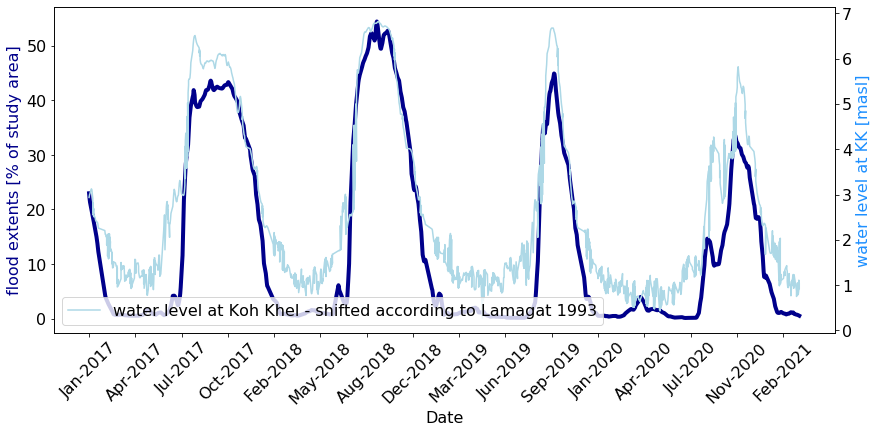

In [26]:
# visualise: 

# Initialise the figure and axes.

fig, ax1 = plt.subplots(1, figsize=(14, 6))

# Set the title for the figure
#fig.suptitle('shifted 23 days', fontsize=15)


# define axes 
y1 = flood_PA['flood']
y2 = flood_PA['wl_KK_same_day']
y3 = flood_PA['wl_KK_shifted']
#y4 = flood_PA['wl_KK_shifted_static']

#x = flood_daily.index
x = date2num(pd.to_datetime(flood_PA.index))

ax2 = ax1.twinx()
ax1.plot(x, y1, color="darkblue", label="flood extents", linewidth=4)
#ax2.plot(x, y2, color="cornflowerblue", label="water level at Koh Khel")
ax2.plot(x, y3, color="lightblue", label="water level at Koh Khel - shifted according to Lamagat 1993")
#ax2.plot(x, y4, color="dodgerblue", label="water level at KK - shifted 12d")

#plt.legend(loc="upper left", title="Legend ", frameon=False)
ax2.legend(loc=0)
#ax1.legend(loc=1)

#plt.xticks(rotation = 45)

ax1.set_xlabel('Date')
ax1.set_ylabel('flood extents [% of study area]', color='darkblue')
ax2.set_ylabel('water level at KK [masl]', color='dodgerblue')


axes = plt.gca()
ax.xaxis_date()
myFmt = mdates.DateFormatter('%b-%Y')

ax1.xaxis.set_major_formatter(myFmt)

plt.xticks(np.arange(min(x), max(x), 100.0))


plt.setp( ax1.xaxis.get_majorticklabels(), rotation=45 )

fig.savefig('Inundations_WaterLevels_PrekArea_shifted', dpi=300)
#fig.savefig('Inundations_WaterLevels_Zone2C_shifted', dpi=300)

plt.show()

